# Imports

In [1]:
!pip install pytabkit    

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.0/364.0 kB 8.6 MB/s eta 0:00:00


In [2]:
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from pytabkit import RealMLP_TD_Classifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

warnings.filterwarnings('ignore')

# Global Configuration

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_STATE = 42
N_FOLDS = 5

print(f"Using device: {DEVICE}")

Using device: cuda


# Data Loading and Preprocessing

In [4]:
train = pd.read_csv("/kaggle/input/playground-series-s6e2/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s6e2/test.csv")
original = pd.read_csv("/kaggle/input/heartdisease/Heart_Disease_Prediction.csv") 

le = LabelEncoder()
train['Heart Disease'] = le.fit_transform(train['Heart Disease'])
original['Heart Disease'] = le.fit_transform(original['Heart Disease'])

base_features = [col for col in train.columns if col not in ['Heart Disease', 'id']] 

def add_engineered_features(df):
    df_temp = df.copy()
    
    for col in base_features: 
        if col in original.columns:
           
            stats = original.groupby(col)['Heart Disease'].agg(['mean', 'median', 'std', 'skew', 'count']).reset_index()
         
            stats.columns = [col] + [f"orig_{col}_{s}" for s in ['mean', 'median', 'std', 'skew', 'count']]
     
            df_temp = df_temp.merge(stats, on=col, how='left') 
 
            fill_values = {
                f"orig_{col}_mean": original['Heart Disease'].mean(),
                f"orig_{col}_median": original['Heart Disease'].median(),
                f"orig_{col}_std": 0,
                f"orig_{col}_skew": 0,
                f"orig_{col}_count": 0
            }
            df_temp = df_temp.fillna(value=fill_values)
            
    return df_temp

train = add_engineered_features(train)
test = add_engineered_features(test) 

X = train.drop(['id', 'Heart Disease'], axis=1)
y = train['Heart Disease']
X_test = test.drop(['id'], axis=1)

# Data Quality Check (Missing & Duplicates)

In [5]:
def check_data_quality(df, name="Dataset"):
    print(f"--- Data Quality: {name} ---")
    print(f"Total Rows: {len(df)}")

    cols_to_check = [c for c in df.columns if c != 'id']
    dupes = df.duplicated(subset=cols_to_check).sum()

    nan_counts = df.isnull().sum()
    total_nans = nan_counts.sum()
    
    print(f"Duplicate Rows (excl. ID): {dupes}")
    print(f"Total NaN values: {total_nans}")
    if total_nans > 0:
        print("\nColumns with NaNs:")
        print(nan_counts[nan_counts > 0])
    print("-" * 30)

check_data_quality(train, "Train")
check_data_quality(test, "Test")

--- Data Quality: Train ---
Total Rows: 630000
Duplicate Rows (excl. ID): 0
Total NaN values: 0
------------------------------
--- Data Quality: Test ---
Total Rows: 270000
Duplicate Rows (excl. ID): 0
Total NaN values: 0
------------------------------


# Feature Uniqueness & Cardinality

In [6]:
def analyze_uniqueness(df):
    unique_stats = []
    for col in df.columns:
        if col == 'id': continue
        
        n_unique = df[col].nunique()
        dtype = df[col].dtype

        category_guess = "Categorical/Ordinal" if n_unique < 25 else "Continuous"
        
        unique_stats.append({
            'Feature': col,
            'Unique Values': n_unique,
            'Data Type': dtype,
            'Heuristic Type': category_guess
        })
    
    return pd.DataFrame(unique_stats).sort_values(by='Unique Values')

uniqueness_df = analyze_uniqueness(train)
print(uniqueness_df)

                     Feature  Unique Values Data Type       Heuristic Type
40  orig_FBS over 120_median              1   float64  Categorical/Ordinal
1                        Sex              2     int64  Categorical/Ordinal
13             Heart Disease              2     int64  Categorical/Ordinal
5               FBS over 120              2     int64  Categorical/Ordinal
20           orig_Sex_median              2   float64  Categorical/Ordinal
..                       ...            ...       ...                  ...
0                        Age             42     int64           Continuous
3                         BP             66     int64           Continuous
9              ST depression             66   float64           Continuous
7                     Max HR             93     int64           Continuous
4                Cholesterol            150     int64           Continuous

[79 rows x 4 columns]


# Visualize Top Skewed Features

Top 6 Most Skewed Features (Absolute Values):
orig_EKG results_count   -15.613416
orig_EKG results_std       6.747575
orig_Slope of ST_count    -5.657311
orig_Thallium_std          4.472673
orig_BP_std               -4.174508
orig_Age_std              -3.145546
dtype: float64


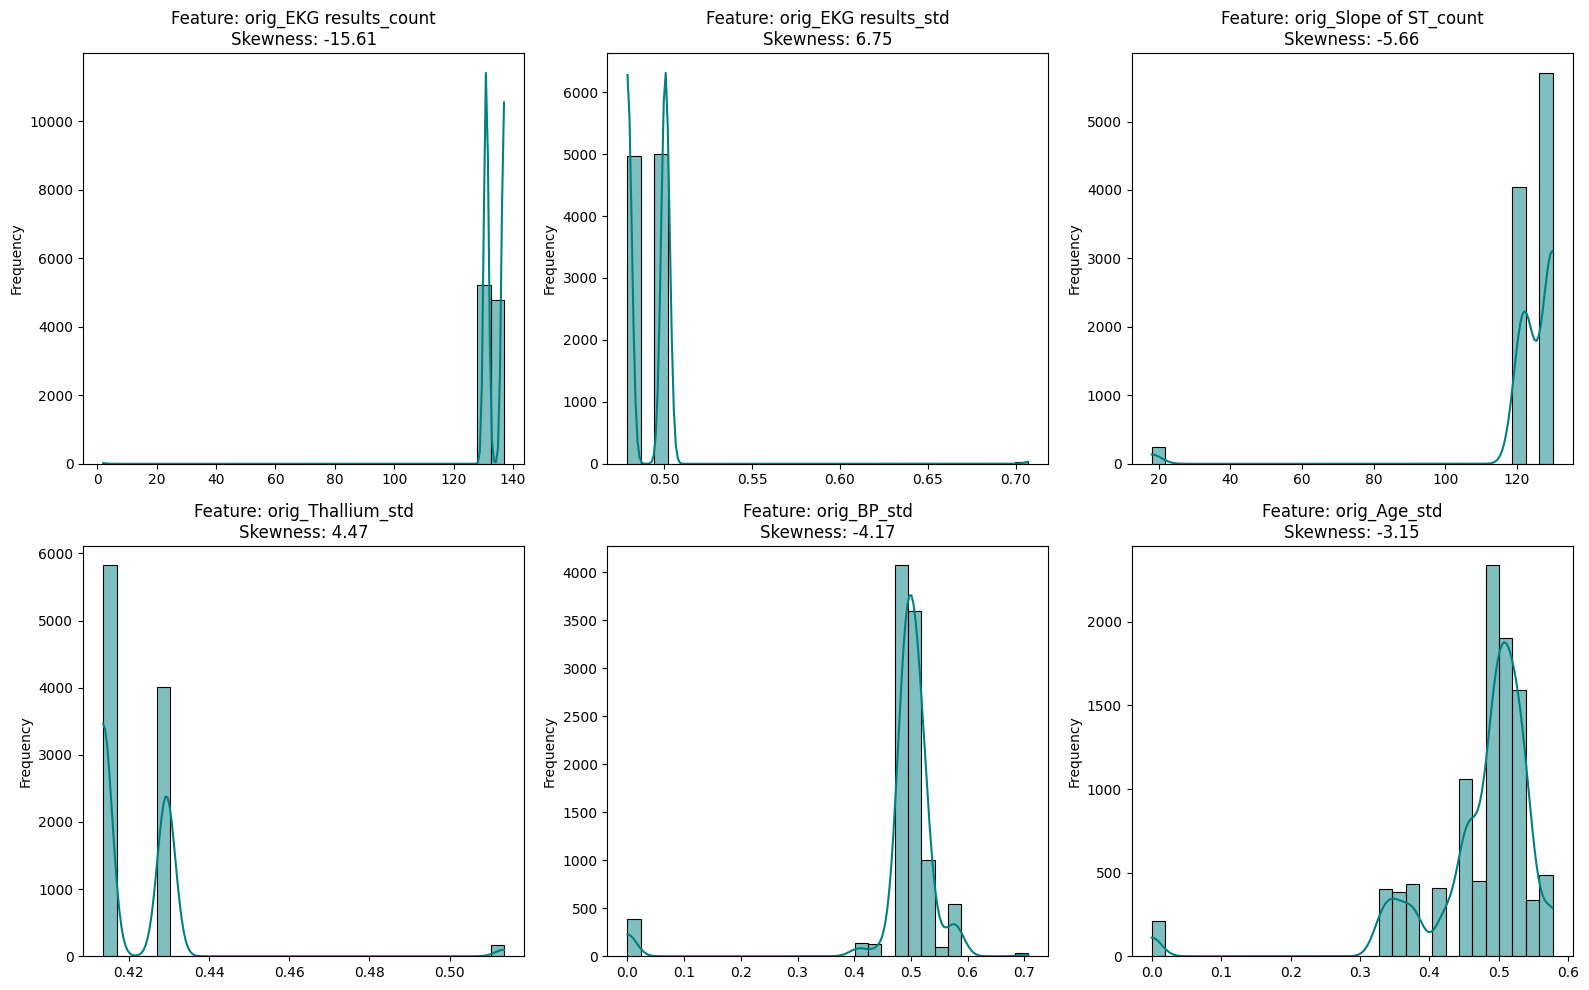

In [7]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

skew_series = X[numeric_cols].skew().abs().sort_values(ascending=False)
top_skewed_features = skew_series.head(6).index.tolist()

print("Top 6 Most Skewed Features (Absolute Values):")
print(X[top_skewed_features].skew())

plt.figure(figsize=(16, 10))
for i, col in enumerate(top_skewed_features):
    plt.subplot(2, 3, i + 1) 
    sns.histplot(X[col].sample(min(10000, len(X))), kde=True, color='teal', bins=30)
    plt.title(f"Feature: {col}\nSkewness: {X[col].skew():.2f}")
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig('skewed_distributions.png')

# Cross-Validation & Training

In [8]:
%%time

param_grid = {
        'device': 'cuda',
        'random_state': 42,
        'verbosity': 2,
        'n_epochs': 100,
        'batch_size': 256, 
        'n_ens': 8, 
        'use_early_stopping': True,
        'early_stopping_additive_patience': 20,
        'early_stopping_multiplicative_patience': 1,
        'act': "mish",
        'embedding_size': 8,
        'first_layer_lr_factor': 0.5962121993798933,
        'hidden_sizes': "rectangular",
        'hidden_width': 384,
        'lr': 0.04, 
        'ls_eps': 0.011498317194338772,
        'ls_eps_sched': "coslog4",
        'max_one_hot_cat_size': 18,
        'n_hidden_layers': 4, 
        'p_drop': 0.07301419697186451,
        'p_drop_sched': "flat_cos",
        'plr_hidden_1': 16, 
        'plr_hidden_2': 8,
        'plr_lr_factor': 0.1151437622270563,
        'plr_sigma': 2.3316811282666916,
        'scale_lr_factor': 2.244801835541429,
        'sq_mom': 1.0 - 0.011834054955582318,
        'wd': 0.02369230879235962,
    } 

for col in X.columns:
    X[col] = X[col].astype(str).astype('category')
    X_test[col] = X_test[col].astype(str).astype('category') 

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))
fold_scores = [] 

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Starting Fold {fold + 1} ---")

    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx] 

    model = RealMLP_TD_Classifier(**param_grid) 
    model.fit(X_tr, y_tr.values, X_val, y_val.values) 

    val_probs = model.predict_proba(X_val)[:, 1] 
    fold_test_probs = model.predict_proba(X_test)[:, 1] 

    oof_preds[val_idx] = val_probs
    test_preds += fold_test_probs / N_FOLDS

    score = roc_auc_score(y_val, val_probs)
    fold_scores.append(score)
    print(f"Fold {fold + 1} ROC-AUC Score: {score:.5f}")

    if DEVICE == 'cuda':
        torch.cuda.empty_cache()


--- Starting Fold 1 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 'orig_FBS over 120_count', 'orig_EKG results_mean', 'orig_EKG results_median', 'or

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.110476
Epoch 2/100: val class_error = 0.109968
Epoch 3/100: val class_error = 0.110897
Epoch 4/100: val class_error = 0.110159
Epoch 5/100: val class_error = 0.109635
Epoch 6/100: val class_error = 0.109040
Epoch 7/100: val class_error = 0.109024
Epoch 8/100: val class_error = 0.109563
Epoch 9/100: val class_error = 0.109484
Epoch 10/100: val class_error = 0.109738
Epoch 11/100: val class_error = 0.110103
Epoch 12/100: val class_error = 0.109587
Epoch 13/100: val class_error = 0.109873
Epoch 14/100: val class_error = 0.109595
Epoch 15/100: val class_error = 0.109770
Epoch 16/100: val class_error = 0.109397
Epoch 17/100: val class_error = 0.109556
Epoch 18/100: val class_error = 0.109079
Epoch 19/100: val class_error = 0.109087
Epoch 20/100: val class_error = 0.109206
Epoch 21/100: val class_error = 0.109310
Epoch 22/100: val class_error = 0.109246
Epoch 23/100: val class_error = 0.109246
Epoch 24/100: val class_error = 0.109683
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 1 ROC-AUC Score: 0.95609

--- Starting Fold 2 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 'orig_FBS over 120_count', 'orig_EKG results_mean', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.112373
Epoch 2/100: val class_error = 0.112095
Epoch 3/100: val class_error = 0.112468
Epoch 4/100: val class_error = 0.112048
Epoch 5/100: val class_error = 0.111659
Epoch 6/100: val class_error = 0.112016
Epoch 7/100: val class_error = 0.111976
Epoch 8/100: val class_error = 0.111833
Epoch 9/100: val class_error = 0.112167
Epoch 10/100: val class_error = 0.111817
Epoch 11/100: val class_error = 0.111960
Epoch 12/100: val class_error = 0.112397
Epoch 13/100: val class_error = 0.112548
Epoch 14/100: val class_error = 0.112571
Epoch 15/100: val class_error = 0.112278
Epoch 16/100: val class_error = 0.112492
Epoch 17/100: val class_error = 0.111683
Epoch 18/100: val class_error = 0.112103
Epoch 19/100: val class_error = 0.111960
Epoch 20/100: val class_error = 0.112008
Epoch 21/100: val class_error = 0.111976
Epoch 22/100: val class_error = 0.112357
Epoch 23/100: val class_error = 0.111968
Epoch 24/100: val class_error = 0.111976
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 2 ROC-AUC Score: 0.95493

--- Starting Fold 3 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 'orig_FBS over 120_count', 'orig_EKG results_mean', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.111556
Epoch 2/100: val class_error = 0.111365
Epoch 3/100: val class_error = 0.110857
Epoch 4/100: val class_error = 0.111206
Epoch 5/100: val class_error = 0.111103
Epoch 6/100: val class_error = 0.110579
Epoch 7/100: val class_error = 0.110929
Epoch 8/100: val class_error = 0.110881
Epoch 9/100: val class_error = 0.111008
Epoch 10/100: val class_error = 0.111024
Epoch 11/100: val class_error = 0.111111
Epoch 12/100: val class_error = 0.111071
Epoch 13/100: val class_error = 0.110873
Epoch 14/100: val class_error = 0.111127
Epoch 15/100: val class_error = 0.110984
Epoch 16/100: val class_error = 0.110921
Epoch 17/100: val class_error = 0.110841
Epoch 18/100: val class_error = 0.110738
Epoch 19/100: val class_error = 0.110881
Epoch 20/100: val class_error = 0.110937
Epoch 21/100: val class_error = 0.110817
Epoch 22/100: val class_error = 0.110929
Epoch 23/100: val class_error = 0.110889
Epoch 24/100: val class_error = 0.111008
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 3 ROC-AUC Score: 0.95581

--- Starting Fold 4 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 'orig_FBS over 120_count', 'orig_EKG results_mean', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.111905
Epoch 2/100: val class_error = 0.111817
Epoch 3/100: val class_error = 0.111929
Epoch 4/100: val class_error = 0.111873
Epoch 5/100: val class_error = 0.111421
Epoch 6/100: val class_error = 0.111500
Epoch 7/100: val class_error = 0.111452
Epoch 8/100: val class_error = 0.111238
Epoch 9/100: val class_error = 0.111484
Epoch 10/100: val class_error = 0.111603
Epoch 11/100: val class_error = 0.111984
Epoch 12/100: val class_error = 0.112016
Epoch 13/100: val class_error = 0.111421
Epoch 14/100: val class_error = 0.111706
Epoch 15/100: val class_error = 0.111770
Epoch 16/100: val class_error = 0.111675
Epoch 17/100: val class_error = 0.111452
Epoch 18/100: val class_error = 0.111405
Epoch 19/100: val class_error = 0.111421
Epoch 20/100: val class_error = 0.111325
Epoch 21/100: val class_error = 0.111278
Epoch 22/100: val class_error = 0.111405
Epoch 23/100: val class_error = 0.111262
Epoch 24/100: val class_error = 0.111635
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 4 ROC-AUC Score: 0.95547

--- Starting Fold 5 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 'orig_FBS over 120_count', 'orig_EKG results_mean', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.111421
Epoch 2/100: val class_error = 0.110794
Epoch 3/100: val class_error = 0.112500
Epoch 4/100: val class_error = 0.111198
Epoch 5/100: val class_error = 0.110579
Epoch 6/100: val class_error = 0.110556
Epoch 7/100: val class_error = 0.110341
Epoch 8/100: val class_error = 0.110913
Epoch 9/100: val class_error = 0.110500
Epoch 10/100: val class_error = 0.110984
Epoch 11/100: val class_error = 0.111532
Epoch 12/100: val class_error = 0.111460
Epoch 13/100: val class_error = 0.110706
Epoch 14/100: val class_error = 0.110738
Epoch 15/100: val class_error = 0.110484
Epoch 16/100: val class_error = 0.110444
Epoch 17/100: val class_error = 0.110325
Epoch 18/100: val class_error = 0.110460
Epoch 19/100: val class_error = 0.110627
Epoch 20/100: val class_error = 0.110746
Epoch 21/100: val class_error = 0.110683
Epoch 22/100: val class_error = 0.110722
Epoch 23/100: val class_error = 0.110421
Epoch 24/100: val class_error = 0.110429
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 5 ROC-AUC Score: 0.95616
CPU times: user 1h 1min 54s, sys: 1min 5s, total: 1h 2min 59s
Wall time: 1h 2min 57s


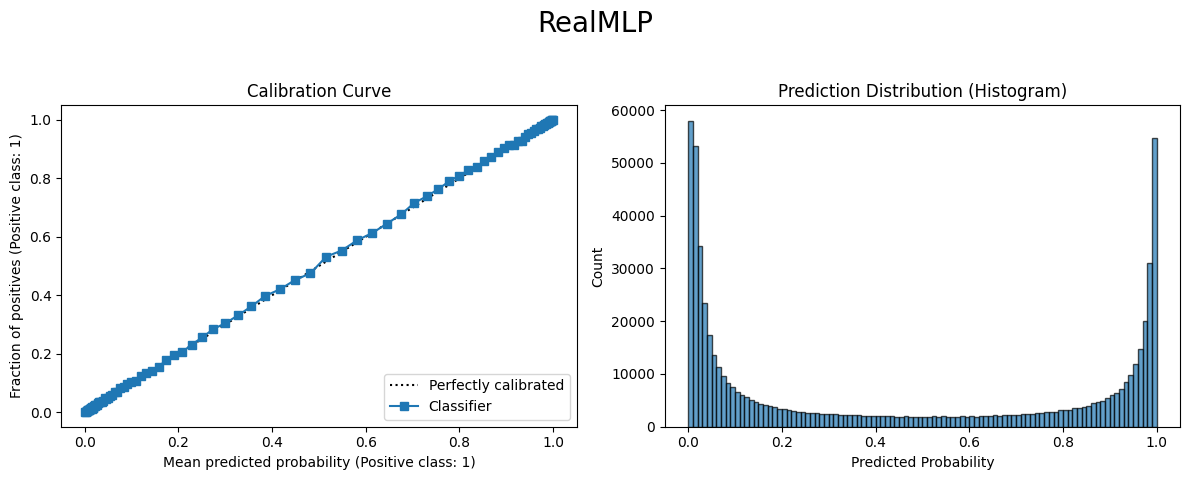

In [9]:
from sklearn.calibration import CalibrationDisplay

plt.figure(figsize=(12, 5)) 
plt.suptitle('RealMLP', fontsize=20) 

ax1 = plt.subplot(1, 2, 1)
CalibrationDisplay.from_predictions(y, oof_preds, n_bins=100, strategy='quantile', ax=ax1)
ax1.set_title('Calibration Curve')

ax2 = plt.subplot(1, 2, 2)
ax2.hist(oof_preds, bins=100, edgecolor='black', alpha=0.7)
ax2.set_title('Prediction Distribution (Histogram)')
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

# Evaluation and Submission

In [10]:
total_oof_score = roc_auc_score(y, oof_preds) 

print("\n" + "="*40)
print(f"Overall OOF ROC-AUC: {total_oof_score:.5f}")
print(f"Mean Fold Score: {np.mean(fold_scores):.5f} (+/- {np.std(fold_scores):.5f})")
print("="*40)

pd.DataFrame({'id': train['id'], 'Heart Disease_prob': oof_preds}).to_csv('oof.csv', index=False)

submission = pd.DataFrame({'id': test['id'], 'Heart Disease': test_preds})
submission.to_csv('submission.csv', index=False)
submission.head() 


Overall OOF ROC-AUC: 0.95565
Mean Fold Score: 0.95569 (+/- 0.00045)


,id,Heart Disease
0,630000,0.945893
1,630001,0.009528
2,630002,0.990296
3,630003,0.005289
4,630004,0.199697


# Baseline 
现在考虑了original的特征并加入了train作为了特征量
使用了frequency版的mlp



1. "Five risk factors account for approximately 50% of the global burden of cardiovascular disease. How the presence or absence of classic risk factors affects lifetime estimates of cardiovascular disease and death from any cause remains unclear."

"Lifetime risk of cardiovascular disease and death from any cause was estimated up to 90 years of age according to the presence or absence of arterial hypertension, hyperlipidemia, underweight and overweight or obesity, diabetes, and smoking at 50 years of age. Differences in life span (in terms of additional life-years free of cardiovascular disease or death from any cause) according to the presence or absence of these risk factors were also estimated."

"The lifetime risk of cardiovascular disease was 24% (95% confidence interval [CI], 21 to 30) among women and 38% (95% CI, 30 to 45) among men for whom all five risk factors were present. In the comparison between participants with none of the risk factors and those with all the risk factors, the estimated number of additional life-years free of cardiovascular disease was 13.3 (95% CI, 11.2 to 15.7) for women and 10.6 (95% CI, 9.2 to 12.9) for men; the estimated number of additional life-years free of death was 14.5 (95% CI, 9.1 to 15.3) for women and 11.8 (95% CI, 10.1 to 13.6) for men. As compared with no changes in the presence of all risk factors, modification of hypertension at an age of 55 to less than 60 years was associated with the most additional life-years free of cardiovascular disease, and modification of smoking at an age of 55 to less than 60 years was associated with the most additional life-years free of death."

"The absence of five classic risk factors at 50 years of age was associated with more than a decade greater life expectancy than the presence of all five risk factors, in both sexes. Persons who modified hypertension and smoking in midlife had the most additional life-years free of cardiovascular disease and death from any cause, respectively." 基于这个考虑扩张特征量

2. 用lgbm+mlp的混合模型
3. 现在age,BP, Cholesterol都label embedding了，再考虑一下是不是应该保留数值呢
4. 混合模型时考虑核心 trick：裁判模型不仅看 MLP 和 CatBoost 的预测值，还看原始数据的特征（Age, Sex...）。

原理：有时候，MLP 在某些特定年龄段（比如 60-70 岁）特别准，而 CatBoost 在年轻人中特别准。如果把原始特征（Age）也喂给裁判模型，裁判就能学会：“哦，这是一个 65 岁的病人，那我要多听 MLP 的意见；如果是个年轻人，我就听 CatBoost 的。”

Broccoli Beef 的代码演示了用 StackingClassifier(..., passthrough=True) 实现了这一点，并获得了分数的微弱提升。
 
